In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import pandas as pd
import glob
import data_utils.data_utils_celeba_pytorch5 as data_utils
import data_utils.network_tuning23 as network_tuning
from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils


import pickle
import numpy as np
import pandas as pd
import os

In [2]:
# Root directory for dataset
dataroot = 'C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness'

# Batch size during training
batch_size = 128

In [3]:
attributes = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\Data\\list_attr_celeba.txt', sep=" ")
attributes.drop('Unnamed: 41',axis=1, inplace=True)
partition = pd.read_csv('C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\list_eval_partition.txt', sep=" ", header=None, names=['im_id','partition'])
matched = attributes.set_index('im_id').join(partition.set_index('im_id')).replace(-1,0)

In [4]:
train_df = matched[matched['partition']==0]
valid_df = matched[matched['partition']==1]
test_df = matched[matched['partition']==2]
#train_df.to_csv('Data\\train.csv')
#valid_df.to_csv('Data\\valid.csv')
#test_df.to_csv('Data\\test.csv')

In [19]:
from PIL import Image
import cv2
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\images"
IMAGE_SHAPE = (60,73)
RESIZE_IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\AlgorithmicFairness\\images_resize"

dirs = os.listdir(IMAGE_PATHS)
for item in dirs:
    img_name = os.path.join(IMAGE_PATHS,item)
    #image = Image.open(img_name)
    #image = image.resize(IMAGE_SHAPE, Image.ANTIALIAS)
    #image.save(os.path.join(RESIZE_IMAGE_PATHS,item), format='JPEG', subsampling=0, quality=100)
    
    img = cv2.imread(img_name, cv2.IMREAD_UNCHANGED)
    resized = cv2.resize(img, IMAGE_SHAPE, interpolation = cv2.INTER_AREA)
    cv2.imwrite(os.path.join(RESIZE_IMAGE_PATHS,item),resized)

Populating the interactive namespace from numpy and matplotlib


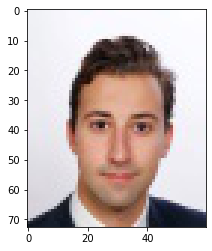

In [20]:
%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img=mpimg.imread(os.path.join(RESIZE_IMAGE_PATHS,item))
imgplot = plt.imshow(img)
plt.show()

In [16]:
IMAGE_SHAPE = [73,60,3]
# Paths to data
TRAIN_PATH =  dataroot + "\\Data\\train.csv" 
VALID_PATH = dataroot + "\\Data\\valid.csv" 
TEST_PATH = dataroot + "\\Data\\test.csv" 
IMAGE_PATHS = "C:\\Users\\cfthe\\OneDrive\\DTU\\Kandidat\\Deep\\celebA_resize3\\"
TARGET_COL = 'Smiling'
NUM_CLASSES = 2

# train holds both X (input) and t (target/truth)
data_train = data_utils.CelebADataset(TRAIN_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)
data_valid = data_utils.CelebADataset(VALID_PATH,IMAGE_PATHS,IMAGE_SHAPE,TARGET_COL)

In [11]:
#test dataloader
dataloader = DataLoader(data_valid, batch_size=128,shuffle=True, num_workers=6)
from tqdm import tqdm_notebook
for i_batch, sample_batched in tqdm_notebook(enumerate(dataloader)):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['target'].size())

    # observe 4th batch and stop.
    if i_batch == 10:
        print('done')
        break

0 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
1 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
2 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
3 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
4 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
5 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
6 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
7 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
8 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
9 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
10 torch.Size([128, 3, 73, 60]) torch.Size([128, 2])
done



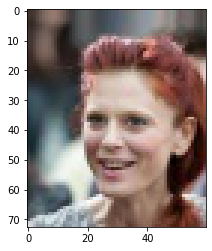

In [12]:
# Test that image look ok
plt.imshow(np.transpose(vutils.make_grid(data_train[1]['image'], padding=2,normalize=True).cpu(),(1,2,0)))

In [24]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout2d, MaxPool2d, BatchNorm2d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [20]:
use_cuda = torch.cuda.is_available()
print("Running GPU.") if use_cuda else print("No GPU available.")


def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

No GPU available.


In [15]:
height, width, channels = IMAGE_SHAPE

conv_out_channels =  16 # <-- Filters in your convolutional layer
kernel_size = 5       # <-- Kernel size
conv_stride = 1       # <-- Stride
conv_pad    = 0       # <-- Padding
 
def conv_dim(dim_size):
    return int(dim_size - kernel_size + 2 * conv_pad / conv_stride + 1)

conv1_h = conv_dim(height)//2
conv1_w = conv_dim(width)//2

# Keep track of features to output layer
features_cat_size = int(conv_out_channels * conv1_h * conv1_w)

conv2_h = conv_dim(conv1_h)//2
conv2_w = conv_dim(conv1_w)//2
        
features_cat_size2 = int(conv_out_channels*2 * conv2_h * conv2_w)

# <-- Number of features concatenated before output layer
  
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.conv_1 = Conv2d(in_channels=channels,
                             out_channels=conv_out_channels,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        
        self.conv_2 = Conv2d(in_channels=conv_out_channels,
                             out_channels=conv_out_channels*2,
                             kernel_size=kernel_size,
                             stride=conv_stride,
                             padding=conv_pad)
        
        self.pool = nn.MaxPool2d(2,2)
        
        self.dropout = Dropout2d(p=0.5)
        
        self.batch1 = BatchNorm2d(conv_out_channels)
        self.batch2 = BatchNorm2d(conv_out_channels*2)

             
        self.l_out = Linear(in_features=features_cat_size2,
                            out_features=NUM_CLASSES,
                            bias=False)
        
    def forward(self, x_img):
        features = []
        out = {}
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        features_img = self.pool(tanh(self.conv_1(x_img)))
        features_img = self.batch1(features_img)
        features_img = self.dropout(features_img)
        features_img = self.pool(tanh(self.conv_2(features_img)))
        features_img = self.batch2(features_img)
        
        features_img = features_img.view(-1, features_cat_size2)

        ## Output layer where all features are in use ##
        
        out['out'] = self.l_out(features_img)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (l_out): Linear(in_features=5760, out_features=2, bias=False)
)


In [26]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()          #<-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

In [21]:
# Function to get label
def get_labels(batch):
    return get_variable(Variable(batch['target']))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(batch['image']))
    }


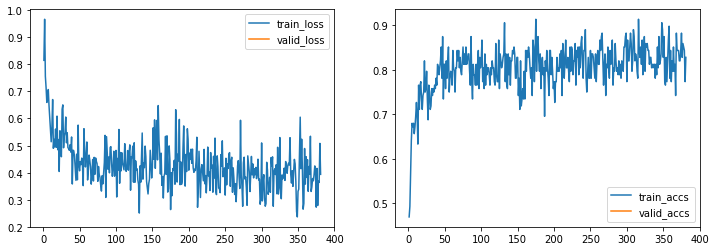

In [17]:
# Setup settings for training 
batch_size=128
max_iter = 199
log_every = 20
eval_every = 200
num_epochs = 2


# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen_train = DataLoader(data_train, batch_size, shuffle=True, num_workers=6)
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)

# Train network
j=0
net.train()
for epoch in range(num_epochs):
    for i, batch_train in enumerate(batch_gen_train):
        j+=1
        if i % eval_every == -1:
            

            # Do the validaiton
            net.eval()
            val_losses, val_accs, val_lengths = 0, 0, 0
            with torch.no_grad(): 
                for batch_valid in batch_gen_valid:
                    num = len(batch_valid['target'])
                    output = net(**get_input(batch_valid))
                    labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
                    val_losses += criterion(output['out'], labels_argmax) * num
                    val_accs += accuracy(output['out'], labels_argmax) * num
                    val_lengths += num

                # Divide by the total accumulated batch sizes
                val_losses /= val_lengths
                val_accs /= val_lengths
                valid_loss.append(get_numpy(val_losses))
                valid_accs.append(get_numpy(val_accs))
                valid_iter.append(j)
        #         print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
                net.train()

        # Train network
        output = net(**get_input(batch_train))
        labels_argmax = torch.max(get_labels(batch_train), 1)[1]
        batch_loss = criterion(output['out'], labels_argmax)

        train_iter.append(j)
        train_loss.append(float(get_numpy(batch_loss)))
        train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # Log i figure
        if i % log_every == 0:
            fig = plt.figure(figsize=(12,4))
            plt.subplot(1, 2, 1)
            plt.plot(train_iter, train_loss, label='train_loss')
            plt.plot(valid_iter, valid_loss, label='valid_loss')
            plt.legend()

            plt.subplot(1, 2, 2)
            plt.plot(train_iter, train_accs, label='train_accs')
            plt.plot(valid_iter, valid_accs, label='valid_accs')
            plt.legend()
            plt.show()
            clear_output(wait=True)
            #print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
            
        if max_iter == i:
            break

In [5]:
df = pd.read_pickle('df.pkl')

In [7]:
i=1
IMAGE_SHAPE = [73,60,3]
layers = df.loc[i,'layers']
activations = df.loc[i,'activations']
conv_out_channels = df.loc[i,'conv_out_channels']
kernel_size = df.loc[i,'kernel_size']
conv_stride = df.loc[i,'conv_stride']
maxpool = int(df.loc[i,'maxpool'])
dropout = df.loc[i,'dropout']
batchnorm = df.loc[i,'batchnorm']
optimizer = df.loc[i,'optimizer']
learning_rate = df.loc[i,'learning_rate']
weight_decay = df.loc[i,'weight_decay']
batch_size = int(df.loc[i,'batch_size'])
num_epochs = df.loc[i,'num_epochs']

net = network_tuning.tune_architecture(layers, activations, IMAGE_SHAPE, conv_out_channels, kernel_size,conv_stride, maxpool, dropout, batchnorm)

In [9]:
net.load_state_dict(torch.load('model1'))
net.eval()

Net(
  (conv_1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (batch1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.0, inplace=False)
  (l_out): Linear(in_features=61824, out_features=2, bias=False)
)

In [13]:
#dataframe for saving predictions
valid_predictions = valid_df.astype(object)
valid_predictions.loc[:,'target'] = valid_predictions.loc[:,'Smiling']
valid_predictions.drop(['Smiling','partition'],axis=1)
valid_predictions['output'] = np.nan
valid_predictions['labels_argmax'] = np.nan
valid_predictions['accuracy'] = np.nan
valid_predictions['criterion'] = np.nan

In [27]:
#calculation predictions on the validation set
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
val_1_losses,val_1_accs,val_1_lengths,val_0_losses,val_0_accs,val_0_lengths = 0, 0, 0, 0, 0, 0
net.eval()
valid_predictions = valid_predictions.astype(object)
with torch.no_grad():
    for batch_valid in batch_gen_valid:
        output = net(**get_input(batch_valid))
        labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
        for i in range(len(batch_valid['file'])):
            valid_predictions.at[batch_valid['file'][i],'output'] = output['out'][i]
            valid_predictions.at[batch_valid['file'][i],'labels_argmax'] = labels_argmax[i]
            valid_predictions.at[batch_valid['file'][i],'accuracy'] = accuracy(output['out'][i:i+1],labels_argmax[i:i+1])
            valid_predictions.at[batch_valid['file'][i],'criterion'] = criterion(output['out'][i:i+1],labels_argmax[i:i+1])

In [72]:
#calculating accuracies for all protected attributes
attributes = matched.iloc[:,0:-1].drop('Smiling',axis=1).columns
df_att = pd.DataFrame(index = attributes, columns=['val_1_loss','val_1_acc','val_0_loss','val_0_acc','val_1_FP','val_1_TP','val_0_FP','val_0_TP'])
batch_gen_valid = DataLoader(data_valid, batch_size, shuffle=True, num_workers=6)
for att in range(0,len(attributes)):
    print(attributes[att])
    
    att_ = valid_predictions.iloc[:][attributes[att]]
    t_ = valid_predictions.iloc[:]['target']
    
    att_1 = np.where(att_==1)
    att_0 = np.where(att_==0)
    
    att_1_t_1 = np.where((att_==1) & (t_==1))
    att_0_t_1 = np.where((att_==0) & (t_==1))
    att_1_t_0 = np.where((att_==1) & (t_==0))
    att_0_t_0 = np.where((att_==0) & (t_==0))
    
    df_att.iloc[att]['val_1_loss'] = np.mean(valid_predictions.iloc[att_1]['criterion'])
    df_att.iloc[att]['val_1_acc'] = np.mean(valid_predictions.iloc[att_1]['accuracy'])
    df_att.iloc[att]['val_0_loss'] = np.mean(valid_predictions.iloc[att_0]['criterion'])
    df_att.iloc[att]['val_0_acc'] = np.mean(valid_predictions.iloc[att_0]['accuracy'])
    df_att.iloc[att]['val_1_FP'] = 1-np.mean(valid_predictions.iloc[att_1_t_0]['accuracy'])
    df_att.iloc[att]['val_0_FP'] = 1-np.mean(valid_predictions.iloc[att_0_t_0]['accuracy'])
    df_att.iloc[att]['val_1_TP'] = np.mean(valid_predictions.iloc[att_1_t_1]['accuracy'])
    df_att.iloc[att]['val_0_TP'] = np.mean(valid_predictions.iloc[att_0_t_1]['accuracy'])

5_o_Clock_Shadow
Arched_Eyebrows
Attractive
Bags_Under_Eyes
Bald
Bangs
Big_Lips
Big_Nose
Black_Hair
Blond_Hair
Blurry
Brown_Hair
Bushy_Eyebrows
Chubby
Double_Chin
Eyeglasses
Goatee
Gray_Hair
Heavy_Makeup
High_Cheekbones
Male
Mouth_Slightly_Open
Mustache
Narrow_Eyes
No_Beard
Oval_Face
Pale_Skin
Pointy_Nose
Receding_Hairline
Rosy_Cheeks
Sideburns
Straight_Hair
Wavy_Hair
Wearing_Earrings
Wearing_Hat
Wearing_Lipstick
Wearing_Necklace
Wearing_Necktie
Young


In [73]:
df_att['TP_OR'] = df_att['val_1_TP'] /df_att['val_0_TP'] 
df_att['FP_OR'] = df_att['val_1_FP'] /df_att['val_0_FP'] 

In [74]:
df_att

,val_1_loss,val_1_acc,val_0_loss,val_0_acc,val_1_FP,val_1_TP,val_0_FP,val_0_TP,TP_OR,FP_OR
5_o_Clock_Shadow,0.21154,0.912154,0.234824,0.902922,0.0645385,0.875,0.0860154,0.891699,0.981273,0.750313
Arched_Eyebrows,0.192681,0.920725,0.245803,0.898188,0.098154,0.935118,0.0788165,0.870534,1.07419,1.24535
Attractive,0.219529,0.90873,0.245671,0.898899,0.0802661,0.900206,0.0851434,0.874603,1.02927,0.942717
Bags_Under_Eyes,0.225673,0.907304,0.233751,0.90315,0.113445,0.921385,0.077102,0.87939,1.04775,1.47137
Bald,0.282306,0.895377,0.231013,0.904194,0.124352,0.912844,0.0822081,0.889599,1.02613,1.51265
Bangs,0.191009,0.920412,0.239137,0.901192,0.069242,0.911212,0.0851231,0.88609,1.02835,0.813433
Big_Lips,0.193448,0.920499,0.239065,0.901028,0.0720667,0.911355,0.0851386,0.886609,1.02791,0.846463
Big_Nose,0.235,0.903702,0.231107,0.904114,0.11306,0.9156,0.0754901,0.879154,1.04146,1.49769
Black_Hair,0.238269,0.904199,0.230443,0.903962,0.0760576,0.881374,0.0849186,0.892318,0.987735,0.895653
Blond_Hair,0.229054,0.902814,0.232624,0.904229,0.0861925,0.895755,0.0825799,0.888774,1.00785,1.04375


In [54]:
np.mean(valid_predictions['accuracy'])

0.9040116776564152

In [94]:
df_att['TP_OR'] = pd.to_numeric(df_att['TP_OR'])
df_att['FP_OR'] = pd.to_numeric(df_att['FP_OR'])

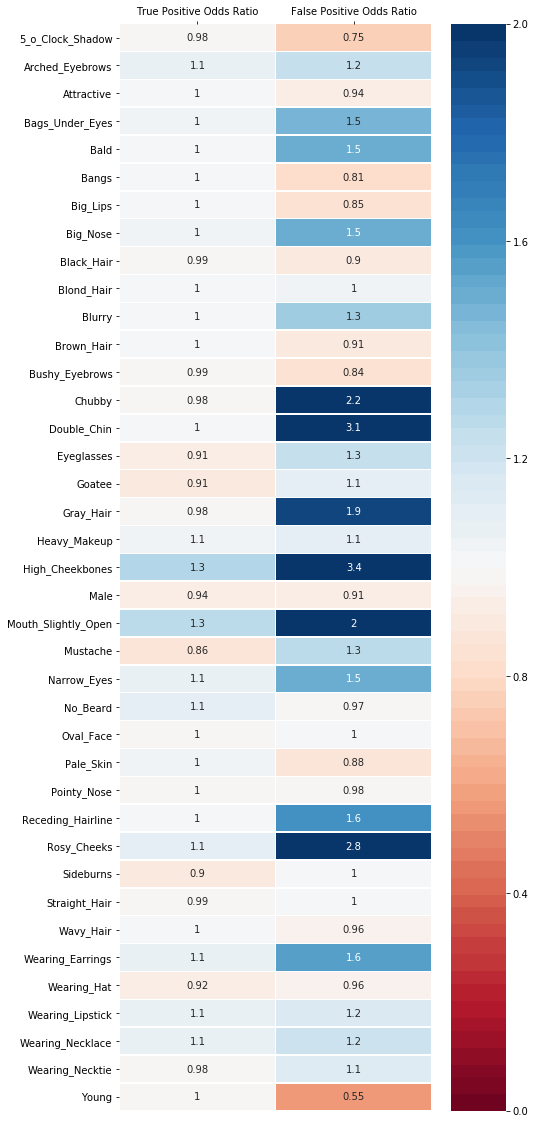

In [130]:
import seaborn as sns
plt.figure(figsize = (7,20))
cmap=sns.color_palette("RdBu",70)
heatmap_kwargs = dict(vmin=0, vmax=2, cmap=cmap,annot=True, linewidths=.5)
ax = sns.heatmap(df_att[['TP_OR','FP_OR']], center=1.0, **heatmap_kwargs)
ax.set_xticklabels(['True Positive Odds Ratio','False Positive Odds Ratio'])
ax.set_yticklabels(list(df_att.index))
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
ax.xaxis.set_ticks_position('top')

In [45]:
valid_predictions

,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,Blond_Hair,...,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young,partition,target,output,labels_argmax,accuracy,criterion
im_id,,,,,,,,,,,,,,,,,,,,,
162771.jpg,0,0,1,0,0,1,1,0,0,0,...,1,0,0,1,1,1,"[tensor(1.0983), tensor(-1.1607)]",tensor(1),tensor(0.),tensor(2.3583)
162772.jpg,0,0,0,0,0,0,0,1,1,0,...,0,0,1,0,1,1,"[tensor(0.7469), tensor(-0.6975)]",tensor(1),tensor(0.),tensor(1.6562)
162773.jpg,0,1,1,0,0,0,1,0,0,0,...,1,0,0,1,1,0,"[tensor(3.6774), tensor(-3.6774)]",tensor(0),tensor(1.),tensor(0.0006)
162774.jpg,1,0,1,0,0,0,0,0,0,0,...,0,0,1,1,1,1,"[tensor(-2.7791), tensor(2.7476)]",tensor(1),tensor(1.),tensor(0.0040)
162775.jpg,0,0,0,0,0,0,0,0,1,0,...,1,0,0,1,1,0,"[tensor(4.6056), tensor(-4.5879)]",tensor(0),tensor(1.),tensor(0.0001)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182633.jpg,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,0,"[tensor(1.2720), tensor(-1.3230)]",tensor(0),tensor(1.),tensor(0.0720)
182634.jpg,0,0,0,0,0,0,1,1,0,0,...,0,0,0,1,1,0,"[tensor(2.9247), tensor(-2.9059)]",tensor(0),tensor(1.),tensor(0.0029)
182635.jpg,0,0,1,0,0,0,0,0,0,0,...,1,0,0,1,1,1,"[tensor(-0.6727), tensor(0.6522)]",tensor(1),tensor(1.),tensor(0.2357)


In [43]:
#funtion to show image along with output and tru target
def show_batch(sample_batched, bias_idx):
    """Show image with landmarks for a batch of samples."""
    images_batch, target_batch, bias = \
            sample_batched['image'], sample_batched['target'], sample_batched['attributes'][:,bias_idx]
    
    batch_size = len(images_batch)
    for i in range(batch_size):

        #grid = utils.make_grid(images_batch)
        plt.figure()
        plt.imshow(np.transpose(vutils.make_grid(images_batch[i], padding=2,normalize=True).cpu(),(1,2,0)))
        plt.axis('off')
        plt.ioff()
        plt.show()
        print(target_batch[i])
        print(bias[i])
        print(output['out'][i])

In [59]:
attributes[21]

'Mouth_Slightly_Open'

<Figure size 432x288 with 0 Axes>

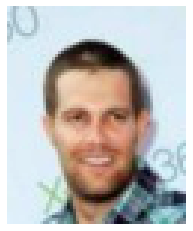

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.2282,  2.1923])


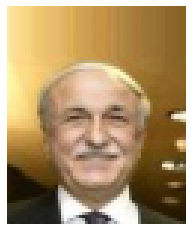

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-1.8043,  1.7955])


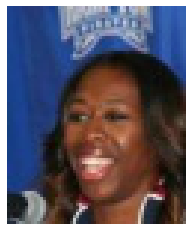

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.4621,  2.4433])


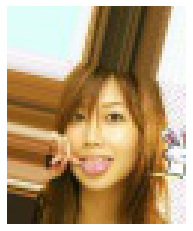

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.0475,  2.0886])


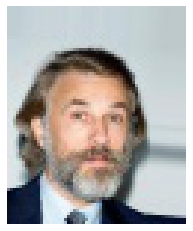

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.0327, -1.0336])


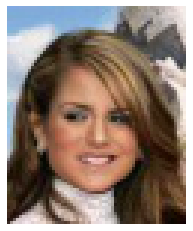

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.7887,  2.7685])


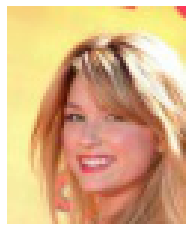

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.2400,  2.2358])


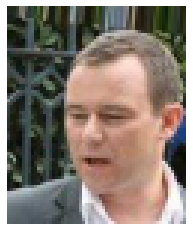

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 2.4823, -2.4983])


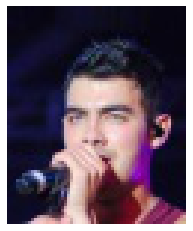

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.5282, -1.6069])


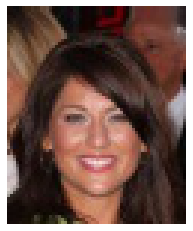

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-4.8122,  4.7870])


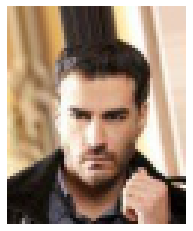

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 4.3442, -4.3708])


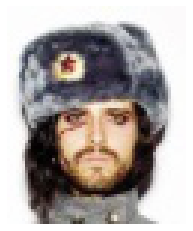

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 2.5473, -2.4839])


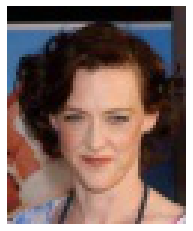

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-0.1575,  0.1739])


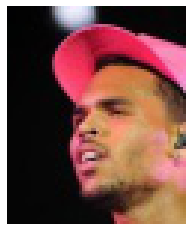

tensor([1., 0.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([ 1.7940, -1.8321])


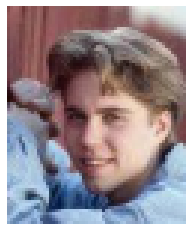

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-0.1426,  0.1143])


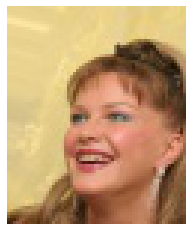

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.2661,  2.2854])


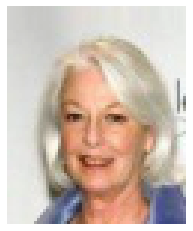

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.4169,  2.3552])


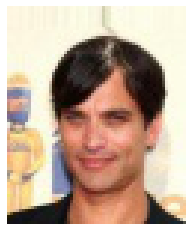

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-1.9736,  1.9671])


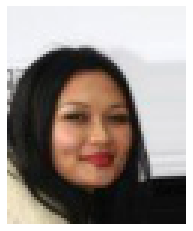

tensor([0., 1.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([-1.2526,  1.2529])


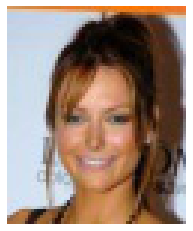

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-2.9960,  2.9459])


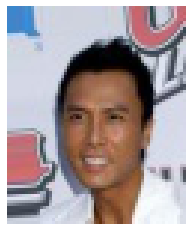

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-0.6736,  0.6423])


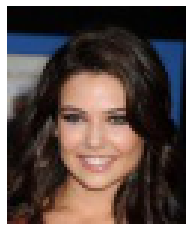

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-4.2605,  4.2334])


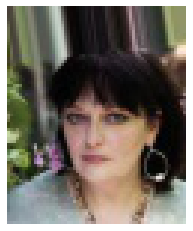

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.5773, -1.6364])


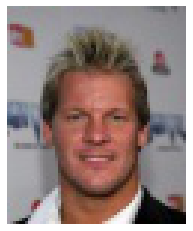

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-0.8486,  0.8297])


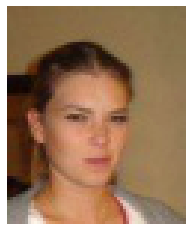

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 1.0749, -1.0985])


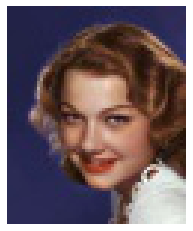

tensor([0., 1.], dtype=torch.float64)
tensor(1., dtype=torch.float64)
tensor([-1.7983,  1.7473])


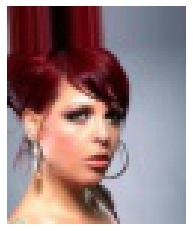

tensor([1., 0.], dtype=torch.float64)
tensor(0., dtype=torch.float64)
tensor([ 2.4696, -2.4649])


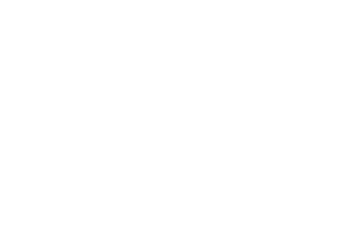

In [60]:
plt.figure()
show_batch(batch_valid,21)
plt.axis('off')
plt.ioff()
plt.show()